In [1]:
using Turing, StatsBase
using Plots, StatsPlots, CSV, HTTP
using Test, DataFrames,  Printf, LightGraphs
import Dates

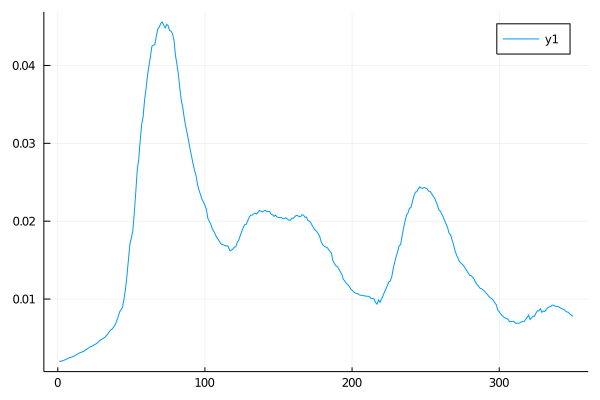

In [2]:
moving_average(vs,n) = [mean(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

data = HTTP.get("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
df = CSV.read(data.body, DataFrame);
CSV.write("positivi_italia.csv", df)

N_tot = 60000000
real_data = df[630:end,"totale_positivi"] / N_tot
# real_data = moving_average(real_data, 7) 
plot(real_data)

In [ ]:
# Data comingn from "Informe n 120 Situacion de COVID-19 en Espana a 2 de marzo"
# Age   Casos   Hosp         ICU         Deads
# <5    258082  2297 (0,9)   100 (0,0)   4 (0,0)
# 5-9   423998  721 (0,2)    23 (0,0)    3 (0,0)
# 10-19 795013  1699 (0,2)   75 (0,0)    8 (0,0)
# 20-29 775049  3351 (0,4)   120 (0,0)   18 (0,0)
# 30-39 980437  5579 (0,6)   298 (0,0)   58 (0,0)
# 40-49 1211805 7129 (0,6)   597 (0,0)   163 (0,0)
# 50-59 763241  9745 (1,3)   1136 (0,1)  533 (0,1)
# 60-69 390176  13833 (3,5)  2037 (0,5)  1338 (0,3)
# 70-79 238103  14277 (6,0)  1473 (0,6)  2367 (1,0)
# 80-89 147744  17053 (11,5) 371 (0,3)   4140 (2,8)
# ≥90   57150   8366 (14,6)  65 (0,1)    3004 (5,3)

wʸ = Weights([258082, 423998, 795013, 775049])
wᵃ = Weights([980437, 1211805, 763241, 390176])
wᵒ = Weights([ 238103, 147744, 57150])

# Probability of hospitalization 0-30
prob_hospʸ = mean([0.9 , 0.2 , 0.2 , 0.4], wʸ) /100

# Probability of hospitalization 30-70
prob_hospᵃ = mean([0.6 , 0.6 , 1.3 , 3.5], wᵃ) /100

# Probability of hospitalization 70+
prob_hospᵒ = mean([6 , 11.5 , 14.6], wᵒ) /100

prob_hosp = [prob_hospʸ , prob_hospᵃ , prob_hospᵒ]

#Letality ICU 70+
# mean([20, 40], wᵒ) / 100

#Letality ICU 30-70
mean([2, 3, 5, 10], wᵃ) / 100

# Probability of dying at home conditioned to the probability of dying 30-70
prob_dhᵃ = ( (58 +163 + 533 + 1338) - (5579 + 7129 + 9745 + 13833) * mean([2, 3, 5, 10], wᵃ) / 100 ) / (980437 + 1211805 + 763241 + 390176)

# Probability of dying at home conditioned to the probability of dying 70+
prob_dhᵒ = ( (2367 + 4140 + 3004) - (14277 + 17053 + 8366) * mean([20, 40], Weights([ 238103, 147744+57150])) / 100 ) / (238103 + 147744 + 57150)

# 3004 / 57150 *100

In [ ]:
'''
AN ATTEMPT WAS MADE TO GET THE NUMBER OF ACTIVE CASES IN SPAIN
BUT THE CORRESPONDING COULUM, ALTHOUGH EXISTING, WAS FULL OF MISSING VALUES
THE END

moving_average(vs,n) = [mean(@view vs[i:(i+n-1)]) for i in 1:(length(vs)-(n-1))]
dates = Date(2021,10,11):Day(1):(today()-Day(1))
dates = Dates.format.( dates, DateFormat("mm-dd-yyyy") )
namefiles = string.("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/",
     dates, ".csv")

out = ones( length(dates) )

for i in 1:length(dates)
    df = HTTP.get(namefiles[i])
    df = CSV.read(df.body, DataFrame)
    df = subset(df, :Country_Region => (x -> x .== "Spain"))
    out[i] = sum( df[: , :Confirmed] )
end
    
plot(moving_average( diff(out), 7) / N_tot )

'''

In [11]:
# Definition of rolling average
moving_average(vs,n) = [mean(@view vs[i:(i+n-1)]) for i in 1:(length(vs)-(n-1))]
import Dates

Nᵍ= [12009992, 26409793, 8906906] # Data from INE, provisional as of July 1, 2021 
N_tot = sum(Nᵍ)

### NUMBER OF ACTIVE CASES
df1 = CSV.read("active_cases.csv", header = false, DataFrame)[:,1]
initial_cond = df1[1] / N_tot
for i in 1:length(df1)
    if df1[i] == 0
        df1[i] = round( (df1[i-1] + df1[i+1])/2 )
    end
end
real_cases = df1[30:end] / N_tot

### NUMBER OF DAILY CASES
# df1 = CSV.read("owid-covid-data.csv", header = true, DataFrame)
# df1 = subset(df1, :location => ByRow(x -> x == "Spain") )
# df1 = subset(df1, :date => ByRow(x -> x >= Dates.Date(2021, 11, 1) ) )
# real_cases = df1[:, :"new_cases_smoothed"] / N_tot
# j = 1
# for i in 1:length(real_cases)
#     if ismissing( real_cases[i] )
#         real_cases[i] = 0.0002635631339617638 + (0.0004990750568215302 - 0.0002635631339617638) / 7 * j
#         j = j + 1
#     end
# end

### NUMBER OF HOSPITALIZATION
df2 = CSV.read("current-covid-patients-hospital.csv", header = true, DataFrame)
df2 = subset(df2, :"Entity" => ByRow(x -> x == "Spain"))
df2 = subset(df2, :Day => ByRow(x -> x >= Dates.Date(2021, 11, 1)) )
real_hosp = df2[30:end, 4] / N_tot;

### NUMBER OF DEATHS
df3 = CSV.read("owid-covid-data.csv", header = true, DataFrame)
df3 = subset(df3, :location => ByRow(x -> x == "Spain"))
real_deaths = subset(df3, :date => ByRow(x -> x > Dates.Date(2021,11,1)))[30:end, :total_deaths]
real_deaths = ( real_deaths .- real_deaths[1] ) / N_tot

real_data = reshape([real_cases ; real_hosp ; real_deaths], (length(real_cases), 3));

# df = HTTP.get("https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/nacional_covid19.csv")
# df = CSV.read(df.body, DataFrame)
# df[500:end, "casos_total"]
# plot(df[500:end,"casos_total"])

In [18]:
include("markov_aux2.jl")
include("markov2.jl")

nᵢ = CSV.read("C:/Users/pierg/Documents/Julia/MMCA-vaccination/population_surface.csv", DataFrame)
sᵢ = Float64.( nᵢ[:, "Superficie"] )
nᵢ = nᵢ[:, "Population"]
N_tot = sum(nᵢ)

G = 3
M = 52
V = 2

Nᵍ= [12009992, 26409793, 8906906] # Data from INE, provisional as of July 1, 2021 

nᵢᵍ =  Nᵍ/sum(Nᵍ) * nᵢ'
nᵢ = sum(nᵢᵍ, dims = 1)
N_tot = sum(nᵢᵍ)

C = [0.5980 0.3849 0.0171
     0.2440 0.7210 0.0350
     0.1919 0.5705 0.2376]

data = CSV.read("C:/Users/pierg/Documents/Julia/MMCA-vaccination/from_to_flow_provinces.csv", DataFrame)
Rᵢⱼ = zeros(M, M)
for count in 1:nrow(data)
    i = data[count,2]
    j = data[count, 3]
    
    Rᵢⱼ[i, j] = data[count, 4]
end
Rᵢⱼ = Rᵢⱼ ./ sum(Rᵢⱼ, dims = 2)

edgelist, Rᵢⱼ = make_edls(Rᵢⱼ)

kᵍ = [11.8, 13.3, 6.6]
kᵍ_h = [3.15, 3.17, 3.28]
kᵍ_w = [1.72, 5.18, 0.0]
pᵍ = [0.3, 1., 0.05] # [0.3, 1.0, 0.05]
ξ = 0.01
σ = 2.5;

βᴵᵥ = 0.03
βᴬᵥ = 0.5 * βᴵᵥ
ηᵍ = [1/2.444, 1/2.444, 1/2.444]
αᵍ = [1/5.671, 1/2.756, 1/2.756]
μᵍ = [1/1., 1/3.915, 1/3.915]

# Rows are the age groups, columns are the vaccination stages
θᵍ = [0.     0.0*(1-0.95);
      0.0  0.0*(1-0.95); 
      0.0  0.0*(1-0.95)]
γᵍ = [0.003  0.003*(1-0.9);
      0.01   0.01*(1-0.9); 
      0.08   0.08*(1-0.9)] 
ωᵍ = [0.  0.0*(1-0.95); 
      0.04  0.04*(1-0.95); 
      0.3  0.3*(1-0.95)]

ζᵍ = [1/7.084, 1/7.084, 1/7.084]
λᵍ = [1/4.084, 1/4.084, 1/4.084]
ψᵍ = [1/7.0, 1/7.0, 1/7.0]
χᵍ = [1/20.0, 1/20.0, 1/20.0]

Λ = 1 / 180
Γ = 1 / 360

T = length(real_cases)

ϵᵍ = [0.1 , 0.4 , 0.5] * 1000
tᶜs = [87, 87+90, T]
ϵᵍs = ϵᵍ .* [0 0 0] # reshape(ϵᵍ, (3, 1))

κ₀s = ones(3) * 0.
ϕs = ones(3) 
δs = ones(3) * 0.

rᵥ = [0., 0.6 ] # Relative risk reduction of the probability of infection
kᵥ = [0., 0.4 ] # Relative risk reduction of the probability of transmission

if (@isdefined population)
    reset_params!(epi_params, population)
end    
population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

E₀ = population.nᵢᵍ * real_cases[1] / 2 #* sum(population.nᵢᵍ ) / 2
A₀ = population.nᵢᵍ * real_cases[1] / 2 #* sum(population.nᵢᵍ ) / 2
I₀ = population.nᵢᵍ * real_cases[1] / 2 #* sum(population.nᵢᵍ ) / 2
H₀ = population.nᵢᵍ / N_tot * real_hosp[1] * sum(population.nᵢᵍ )
R₀ = population.nᵢᵍ / N_tot * 1e5 ### NUMERO REALISTICO?
S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;

set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

In [30]:
#### CALIBRATION 

import ForwardDiff

@model function fit_mmca(data, epi_params, population)
    σ1 ~ InverseGamma(1, 2)
#     σ2 ~ InverseGamma(1, 2)
    βᴵᵥ ~ truncated(Normal(0.055, 0.02), 0.0, 0.15)
    ηᵍ ~ truncated(Normal(0.138, 0.1), 0, 1.)
    αᵍ ~ truncated(Normal(0.382, 0.1), 0, 1.)
    μᵍ ~ truncated(Normal(0.651, 0.1), 0, 1.)
#     ωᵍ ~ truncated(Normal(0.1, 0.05), 0, 1.)
#     γᵍ ~ truncated(Normal(0.004, 0.002), 0, 1.)
#     R₀ ~ Uniform(1e4, 1e5)
    
    aa = ForwardDiff.value(βᴵᵥ)
    
    bb = ForwardDiff.value(ηᵍ)
    bb = [bb, bb, bb]
    
    cc = ForwardDiff.value(αᵍ)
    cc = [cc, cc, cc]
    
    dd = ForwardDiff.value(μᵍ)
    dd = [dd, dd, dd]
    
#     ee = ForwardDiff.value(ωᵍ)
#     ee = [1  (1-0.95); 1   (1-0.95); 1   (1-0.95)] .* ee
    
#     ff = ForwardDiff.value(γᵍ)
#     ff = [1  (1-0.9); 1   (1-0.9); 1   (1-0.9)] .* ff
    
#     R₀ = population.nᵢᵍ / N_tot * ForwardDiff.value(R₀)
    S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
    
    reset_params!(epi_params, population) 
    epi_params = Epidemic_Params(aa, aa * 0.5, bb, cc, dd, θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

    set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
    run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
    
    aux = time_series(epi_params, population)
    predict1 = aux.cases / sum(population.nᵢᵍ)
#     predict3 = aux.deaths / sum(population.nᵢᵍ) 
    
    for i = 1:length(predict1)
        data[i, 1] ~ Normal(predict1[i], σ1)
#         data[i, 3] ~ Normal(predict3[i], σ2)
    end
end
   
model = fit_mmca(real_cases, epi_params, population)

# chain = mapreduce(sample(model, NUTS(.65),1000), chainscat, 1)
# chain = sample(model, NUTS(.65), chainscat(), 1000, progress=false)
samples = 50
chain = sample(model, NUTS(.65), samples)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\pierg\.julia\packages\Turing\y0DW3\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 1 days, 1:56:37


Chains MCMC chain (50×17×1 Array{Float64, 3}):

Iterations        = 26:1:75
Number of chains  = 1
Samples per chain = 50
Wall duration     = 93535.72 seconds
Compute duration  = 93535.72 seconds
parameters        = βᴵᵥ, μᵍ, αᵍ, ηᵍ, σ1
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Missing   Float64   Float64      ⋯

          σ1    0.0204    0.0023     0.0003   missing    1.6038    1.7509      ⋯
         βᴵᵥ    0.0565    0.0022     0.0003   missing    9.8220    1.0222      ⋯
          ηᵍ    0.1269    0.0094     0.0013   missing    8.7390    1.0860      ⋯
          αᵍ    0.3065    0.0090     0.0013   missing   14.3341    0.9834      ⋯
          μᵍ    0.5895    0.0524     0.0074   missing 

In [31]:
plt1 = plot(real_cases, linewidth = 3 , color = "red", label = "data")
chain2 = Array(chain)
prediction1 = Array{Float64, 2}(undef, length(real_cases), samples)
for ii in 1:samples
    β = chain2[ii,2]
    ηᵍ = [1, 1, 1] * chain2[ii,3]
    αᵍ = [1, 1, 1] * chain2[ii,4] 
    μᵍ = [1, 1, 1]  * chain2[ii,5]
    epi_params = Epidemic_Params(β, β * 0.5, ηᵍ, αᵍ, μᵍ , θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);
    
#     R₀ = population.nᵢᵍ / N_tot * chain2[ii, 6] 
    H₀ = population.nᵢᵍ / N_tot * real_hosp[1] * sum(population.nᵢᵍ ) 
    S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
    set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
    run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
    
    prediction1[:, ii] = time_series(epi_params, population).cases / N_tot
#     prediction2 = time_series(epi_params, population).deaths / N_tot
    plot!(plt1, prediction1[:, ii], alpha = 0.1, label = "", color = "black")
#     plot!(plt2, prediction2, alpha = 0.1, label = "", color = "black")    
end
# plot!([quantile(prediction1[i,:], 0.025) for i in 1:127 ], 
#     fillrange = [quantile(prediction1[i,:], 0.975) for i in 1:127 ], 
#     alpha = 0.2, color = "blue")

In [36]:
plt1 = plot(real_cases, linewidth = 3 , color = "red", label = "data")
plot(plt1, grid = false)
plot!([median(prediction1[i,:]) for i in 1:T ], color = "blue", label = "calibration")
plot!([quantile(prediction1[i,:], 0.05) for i in 1:T ], 
    fillrange = [quantile(prediction1[i,:], 0.95) for i in 1:T ], 
    alpha = 0.5, color = "blue", label = "95% CI")

png("fit-50samples.png")

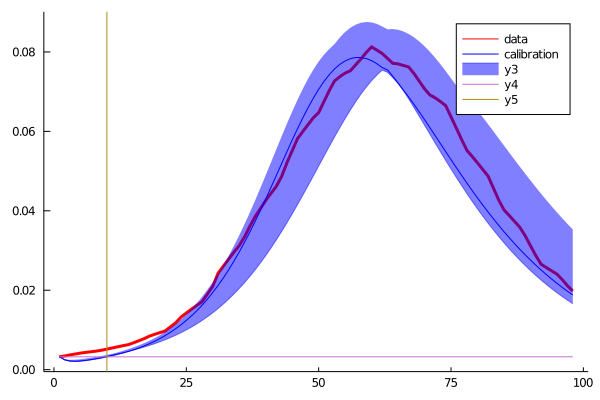

In [26]:
plt1 = plot(real_cases, linewidth = 3 , color = "red", label = "data")
plot(plt1, grid = false)
plot!([median(prediction1[i,:]) for i in 1:T ], color = "blue", label = "calibration")
plot!([quantile(prediction1[i,:], 0.05) for i in 1:T ], 
    fillrange = [quantile(prediction1[i,:], 0.95) for i in 1:T ], 
    alpha = 0.5, color = "blue")
plot!(real_cases[1] * ones(T))
vline!([10])

In [29]:
[median(prediction1[i,:]) for i in 1:T ][10]

0.003289661675915099

In [33]:
df1 = DataFrame( median = [median(prediction1[i,:]) for i in 1:T ], 
quantile_down = [quantile(prediction1[i,:], 0.05) for i in 1:T ],
quantile_up = [quantile(prediction1[i,:], 0.95) for i in 1:T ],
data = real_cases )
CSV.write("calibration_prova2.csv", df1)

"calibration_prova1.csv"

In [ ]:
plt1 = scatter(real_cases, linewidth = 3 , color = "black", label = "data")
chain2 = Array(chain)

## MEAN
β = summarystats(chain)[:, :mean][2] 
ηᵍ = summarystats(chain)[:, :mean][3] * [1, 1, 1]
αᵍ = summarystats(chain)[:, :mean][4] * [1, 1, 1]
#     λᵍ = chain2[ii,7] * [1, 1, 1]
#     γᵍ = [1  (1-0.9); 1   (1-0.9); 1   (1-0.9)] .* chain2[ii, 8]
epi_params = Epidemic_Params(β, β * 0.5, ηᵍ, αᵍ, μᵍ , θᵍ, γᵍ,
                         ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

R₀ = population.nᵢᵍ / N_tot * summarystats(chain)[:, :mean][5] 
S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

prediction_mean = time_series(epi_params, population).cases / N_tot
plot!(plt1, prediction_mean, linewidth = 2, label = "", color = "blue")

## LOWER BOUND
β = quantile(chain)[:, Symbol("2.5%")][2] 
ηᵍ = quantile(chain)[:, Symbol("2.5%")][3] * [1, 1, 1]
αᵍ = quantile(chain)[:, Symbol("2.5%")][4] * [1, 1, 1]
#     λᵍ = chain2[ii,7] * [1, 1, 1]
#     γᵍ = [1  (1-0.9); 1   (1-0.9); 1   (1-0.9)] .* chain2[ii, 8]
epi_params = Epidemic_Params(β, β * 0.5, ηᵍ, αᵍ, μᵍ , θᵍ, γᵍ,
                         ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

R₀ = population.nᵢᵍ / N_tot * quantile(chain)[:, Symbol("2.5%")][5] 
S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

lower = time_series(epi_params, population).cases / N_tot           
            
## UPPER BOUND
β = quantile(chain)[:, Symbol("97.5%")][2] 
ηᵍ = quantile(chain)[:, Symbol("97.5%")][3] * [1, 1, 1]
αᵍ = quantile(chain)[:, Symbol("97.5%")][4] * [1, 1, 1]
#     λᵍ = chain2[ii,7] * [1, 1, 1]
#     γᵍ = [1  (1-0.9); 1   (1-0.9); 1   (1-0.9)] .* chain2[ii, 8]
epi_params = Epidemic_Params(β, β * 0.5, ηᵍ, αᵍ, μᵍ , θᵍ, γᵍ,
                         ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

R₀ = population.nᵢᵍ / N_tot * quantile(chain)[:, Symbol("97.5%")][5] 
S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

upper = time_series(epi_params, population).cases / N_tot
                        
plot!(lower, fillrange = upper, alpha = 0.5, color = "blue")


plot(plt1)

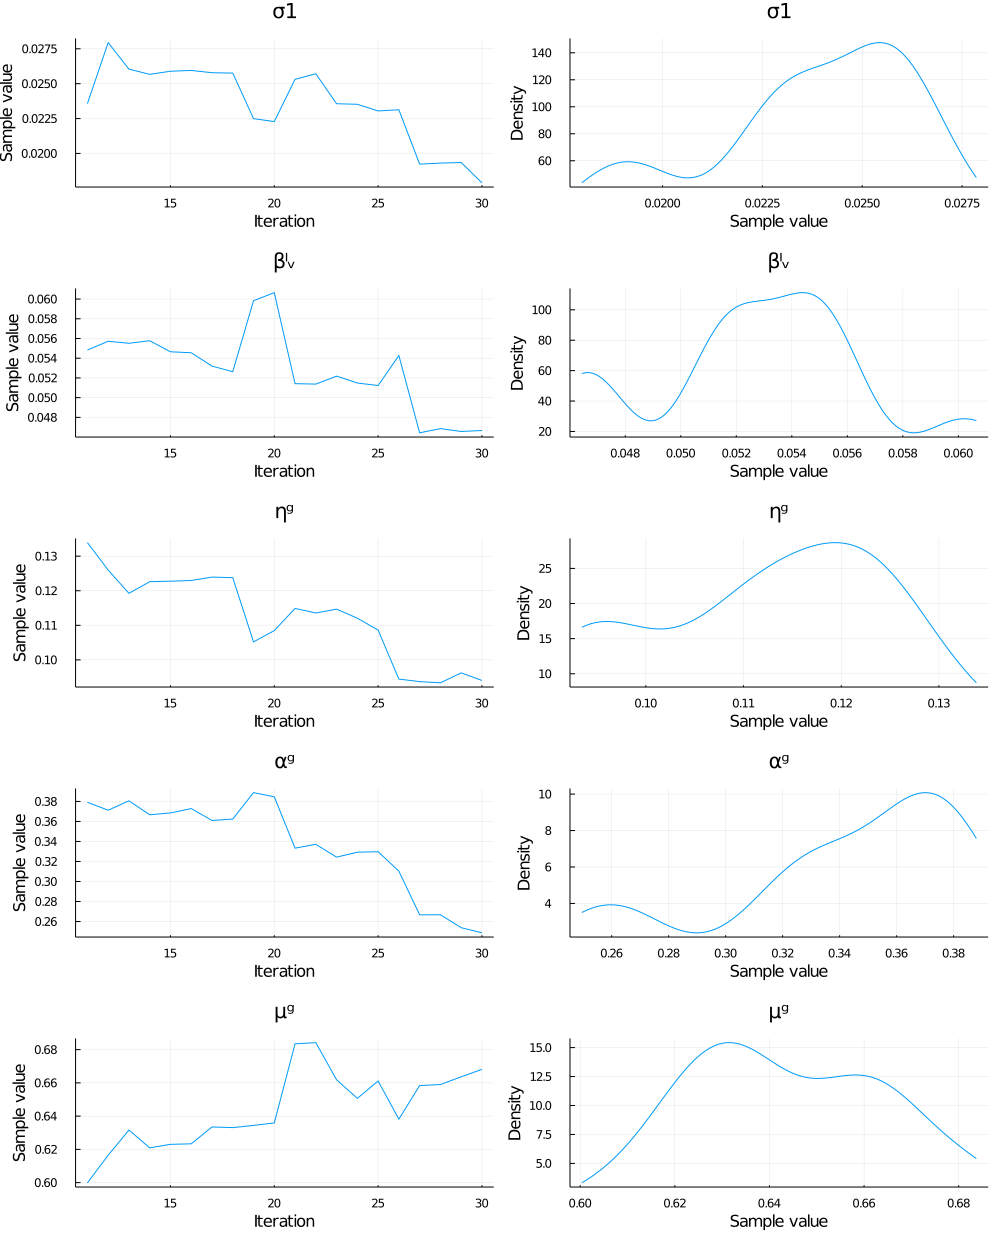

In [17]:
plot(chain)

In [60]:
#### ALTERNATIVE APPROACH TO CALIBRATION

import ForwardDiff
T = 500

@model function fit_mmca(data, epi_params, population)
    σ1 ~ InverseGamma(1, 2)
    σ2 ~ InverseGamma(1, 2)
    βᴵᵥ ~ truncated(Normal(0.04, 0.02), 0.0, 0.15)
    ηᵍ ~ truncated(Normal(0.4, 0.1), 0, 1.)
    αᵍ ~ truncated(Normal(0.4, 0.1), 0, 1.)
    μᵍ ~ truncated(Normal(0.4, 0.1), 0, 1.)
    ωᵍ ~ truncated(Normal(0.1, 0.05), 0, 1.)
    γᵍ ~ truncated(Normal(0.004, 0.002), 0, 1.)
    R₀ ~ Uniform(5e4, 3e5)
    
    aa = ForwardDiff.value(βᴵᵥ)
    
    bb = ForwardDiff.value(ηᵍ)
    bb = [bb, bb, bb]
    
    cc = ForwardDiff.value(αᵍ)
    cc = [cc, cc, cc]
    
    dd = ForwardDiff.value(μᵍ)
    dd = [dd, dd, dd]
    
    ee = ForwardDiff.value(ωᵍ)
    ee = [1  (1-0.95); 1   (1-0.95); 1   (1-0.95)] .* ee
    
    ff = ForwardDiff.value(γᵍ)
    ff = [1  (1-0.9); 1   (1-0.9); 1   (1-0.9)] .* ff
    
    E₀ = population.nᵢᵍ * 200 / N_tot
    A₀ = population.nᵢᵍ * 200 / N_tot
    I₀ = population.nᵢᵍ * 200 / N_tot
    H₀ = population.nᵢᵍ * 0    
    R₀ = population.nᵢᵍ / N_tot * ForwardDiff.value(R₀)
    S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
    
    reset_params!(epi_params, population) 
    epi_params = Epidemic_Params(aa, aa * 0.5, bb, cc, dd, θᵍ, ff,
                             ζᵍ, λᵍ, ee, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

    set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
    run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
    
    t_init = argmin( abs.(real_hosp[1]*N_tot .- time_series(epi_params, population).icus) )
    aux2 = t_init
    
    count = 1
    while (t_init + length(data[:,1]) ) > T*count
#         @printf("ciao %u \n", count)
        count = count + 1
        reset_params!(epi_params, population) 
        epi_params = Epidemic_Params(aa, aa * 0.5, bb, cc, dd, θᵍ, ff,
                                 ζᵍ, λᵍ, ee, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T*count, V);
        set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
        run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
        
        t_init = argmin( abs.(real_hosp[1]*N_tot .- time_series(epi_params, population).icus) )
    end
    
    aux = time_series(epi_params, population)
    predict1 = aux.cases[t_init:(t_init + length(data[:,1]) - 1)] / sum(population.nᵢᵍ)
    predict3 = aux.deaths[t_init:(t_init + length(data[:,1]) - 1)] / sum(population.nᵢᵍ) 
        
    
    for i = 1:length(data[:,1])
        data[i, 1] ~ Normal(predict1[i], σ1)
        data[i, 3] ~ Normal(predict3[i], σ2)
    end
end
   
model = fit_mmca(real_data, epi_params, population)

# chain = mapreduce(sample(model, NUTS(.65),1000), chainscat, 1)
# chain = sample(model, NUTS(.65), chainscat(), 1000, progress=false)
samples = 20
chain = sample(model, NUTS(.65), samples)

LoadError: syntax: incomplete: premature end of input

In [ ]:
plt1 = plot(real_cases, linewidth = 3 , color = "red", label = "data")
plt2 = plot(real_hosp, linewidth = 3 , color = "red", label = "data")
plt3 = plot(real_deaths, linewidth = 3 , color = "red", label = "data")
chain2 = Array(chain)
prediction1 = Array{Array{Float64, T}, sample}
for ii in 1:samples
    T = 150
    β = chain2[ii,3] 
    ηᵍ = chain2[ii,4] * [1, 1, 1]
    αᵍ = chain2[ii,5] * [1, 1, 1]
    μᵍ = chain2[ii,6] * [1, 1, 1]
    ωᵍ = [1  (1-0.95); 1   (1-0.95); 1   (1-0.95)] .* chain2[ii, 7]
    γᵍ = [1  (1-0.9); 1   (1-0.9); 1   (1-0.9)] .* chain2[ii, 8]
    epi_params = Epidemic_Params(β, β * 0.5, ηᵍ, αᵍ, μᵍ , θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);
    
    
    R₀ = population.nᵢᵍ / N_tot * chain2[ii, 9]
    H₀ = population.nᵢᵍ / N_tot * real_hosp[1] * sum(population.nᵢᵍ ) 
    S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5;
    set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
    run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
    
    prediction1 = time_series(epi_params, population).cases / N_tot
    prediction2 = time_series(epi_params, population).icus / N_tot
    prediction3 = time_series(epi_params, population).deaths / N_tot
    plot!(plt1, prediction1, alpha = 0.1, label = "", color = "black")
    plot!(plt2, prediction2, alpha = 0.1, label = "", color = "black")
    plot!(plt3, prediction3, alpha = 0.1, label = "", color = "black")    
end
plot(plt1, plt2, plt3, layout=(1,3))